# **Генерация оффлайн мерчантов и клиентов**

- **ноутбуки лучше просматривать** на Github pages, т.к. при просмотре прямо в репозитории могут быть проблемы с отображением, например, обрезка вывода с широкими датафреймами. **Если в адресной строке браузера есть** `iaroslav-dzh.github.io`, то вы уже на Github pages.  
Ссылки:
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/notebooks/03_%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D1%84%D1%84%D0%BB%D0%B0%D0%B9%D0%BD_%D0%BC%D0%B5%D1%80%D1%87%D0%B0%D0%BD%D1%82%D0%BE%D0%B2_%D0%B8_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2.html)** на этот ноутбук
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/02_Страница_генератора_транзакций.html)** на страницу генератора где есть все ноутбуки   

**Информация о ноутбуке**
- генерация оффлайн мерчантов для каждого города:
    - мерчанты в каждой категории товаров/услуг
    - создание координат в пределах городов для каждого мерчанта
    - уникальные id для каждого мерчанта
- создание датасета с клиентами:
    - возьмем ранее очищенный датасет
    - добавим клиентам информацию о городах
    - сместим даты рождения клиентов на ~30 лет вперед для большей релевантности к 2025 году

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pyarrow
from data_generator.utils import load_configs, gen_trans_coordinates

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.chdir("..")
os.getcwd()

'c:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

In [7]:
# Загрузка базовых конфигов
base_cfg = load_configs("./config/base.yaml")

In [8]:
# Пути к файлам
data_paths = base_cfg["data_paths"]

In [9]:
cities_path = data_paths["base"]["cities"]
cities = gpd.read_file(cities_path)

<br>

# **Генерация оффлайн мерчантов**
- создание мерчантов для каждого города с разными координатами

<br>

In [10]:
# загрузим датасет по фрод транзакциям для заимстования категорий товаров и их средних цен, и других параметров.
# Он взят с Kaggle вот отсюда: https://www.kaggle.com/datasets/kartik2112/fraud-detection

fraud_kaggle = pd.read_csv("./data/raw/fraudTest.csv.zip", \
                          compression="zip")

In [11]:
fraud_kaggle.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0


## 1. Данные по категориям покупок
- в целом нужны для генерации транзакций, но сейчас нужны названия категорий и их онлайн статус для создания оффлайн мерчантов на основании оффлайн категорий

In [12]:
category_stats = fraud_kaggle.groupby("category").agg({"amt":["mean","std"], "category":"count"})
category_stats.columns = ["avg_amt", "amt_std", "cat_count"]
category_stats = category_stats.sort_values("cat_count",ascending=False).reset_index()
category_stats

,category,avg_amt,amt_std,cat_count
0,gas_transport,63.577001,15.828399,56370
1,grocery_pos,115.885327,51.552330,52553
2,home,57.995413,48.085281,52345
3,shopping_pos,76.862457,232.484678,49791
4,kids_pets,57.506913,48.748482,48692
5,shopping_net,83.481653,237.219758,41779
6,entertainment,63.984840,64.229935,40104
7,personal_care,48.233021,49.410941,39327
8,food_dining,50.777938,48.449053,39268
9,health_fitness,53.867432,47.965251,36674


**Выгрузка category_stats в csv файл**  
Эти данные понадобятся в других ноутбуках

In [86]:
category_stats.to_csv("./data/base/category_stats.csv", index=False)

In [13]:
# т.к. генерируем оффлайн мерчантов, то берем оффлайн категории

offline_categories = category_stats[~category_stats.category.str.contains("net")].reset_index(drop=True)
offline_categories

,category,avg_amt,amt_std,cat_count
0,gas_transport,63.577001,15.828399,56370
1,grocery_pos,115.885327,51.552330,52553
2,home,57.995413,48.085281,52345
3,shopping_pos,76.862457,232.484678,49791
4,kids_pets,57.506913,48.748482,48692
5,entertainment,63.984840,64.229935,40104
6,personal_care,48.233021,49.410941,39327
7,food_dining,50.777938,48.449053,39268
8,health_fitness,53.867432,47.965251,36674
9,misc_pos,62.182246,133.987228,34574


<br>

## 2. Кросс джойн категорий и городов - подготовительная таблица мерчантов
- таким образом получим все категории во всех городах, чтобы в каждом городе были мерчанты всех категорий

In [14]:
# подготовительный датафрейм для генерации оффлайн мерантов
# cross join чтобы к каждому городу присоединить категорию покупки. Это будет категория мерчанта

offline_merchants_prep = cities.merge(offline_categories, how="cross").sort_values("population", ascending=False)
offline_merchants_prep.head(3)

,region,city,timezone,lat,lon,population,city_id,geometry,category,avg_amt,amt_std,cat_count
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",gas_transport,63.577001,15.828399,56370
1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",grocery_pos,115.885327,51.552330,52553
2,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",home,57.995413,48.085281,52345


In [15]:
offline_merchants_prep.columns

Index(['region', 'city', 'timezone', 'lat', 'lon', 'population', 'city_id',
       'geometry', 'category', 'avg_amt', 'amt_std', 'cat_count'],
      dtype='object')

In [16]:
# Уберем некоторые колонки

offline_merchants_prep.drop(columns=['region', 'timezone', 'population','avg_amt', \
                                     'amt_std', 'cat_count'], inplace=True)

<br>

## 3. Увеличение количества мерчантов в каждом городе
- в каждом городе будет несколько мерчантов на каждую категорию

In [17]:
# сделаем 8 мерчантов по каждой категории в каждом городе

offline_merchants = offline_merchants_prep.copy()

for i in range(1,8):
    df = offline_merchants_prep.copy()
    offline_merchants = pd.concat([offline_merchants, df], ignore_index=True)

In [18]:
offline_merchants.shape

(6776, 6)

<br>

## 4. Генерация id мерчантов

In [19]:
# дадим мерчантам id. Просто числа, начиная с 1

merchant_id = 1
for row in offline_merchants.itertuples():
        offline_merchants.loc[row.Index, "merchant_id"] = merchant_id
        merchant_id += 1

In [20]:
# проверим что все id уникальные

offline_merchants.merchant_id.nunique()

6776

In [21]:
offline_merchants.head(2)

,city,lat,lon,city_id,geometry,category,merchant_id
0,Москва,55.753879,37.620373,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",gas_transport,1.0
1,Москва,55.753879,37.620373,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",grocery_pos,2.0


<br>

## 5. Генерация координат для мерчантов в каждом городе

In [22]:
# для каждого мерчанта генерируем свои координаты. цикл while для случаев если gen_trans_coordinates не вернет точек внутри города т.е. пустая серия

for row in offline_merchants.itertuples():
    points = pd.Series()
    while points.empty:
        points, gdp_poly = gen_trans_coordinates(row.geometry, 20)
    offline_merchants.loc[row.Index, "merchant_loc"] = points.iloc[0,0]

In [23]:
offline_merchants.merchant_loc.isna().sum()

np.int64(0)

In [24]:
offline_merchants.merchant_loc.nunique()

6776

In [25]:
# Проверка результата на нескольких случайных городах
six_random_cities_check = offline_merchants \
                            .query("city in ['Нижний Новгород', 'Калининград', 'Магнитогорск', 'Екатеринбург', 'Братск', 'Махачкала']") \
                            [["city", "geometry", "merchant_loc"]]

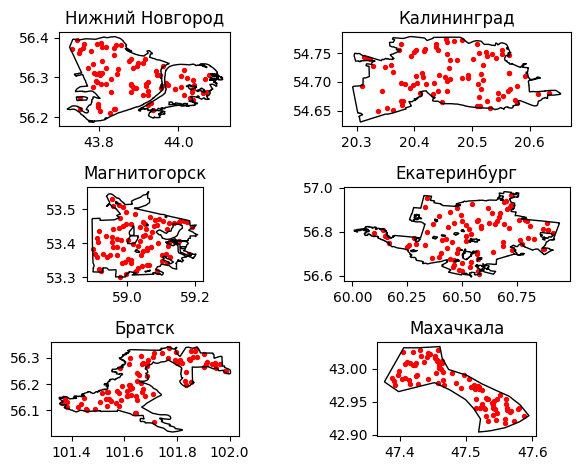

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2)

six_random_cities_names = [['Нижний Новгород', 'Калининград'], \
                           ['Магнитогорск', 'Екатеринбург'], ['Братск', 'Махачкала']]
for row, two_cities in zip(axes, six_random_cities_names):
    for ax, city in zip(row, two_cities):
        gpd.GeoSeries(six_random_cities_check.query("city == @city").head(1).geometry).boundary.plot(linewidth=1, edgecolor="black", ax=ax)
        gpd.GeoSeries(six_random_cities_check.query("city == @city").merchant_loc).plot(ax=ax, linewidth=1, color="red", markersize=8)
        ax.set_title(city)
        # ax.set_xlim(minx, maxx)
        # ax.set_ylim(miny, maxy)
plt.tight_layout()
plt.show()

In [27]:
offline_merchants.head(2)

,city,lat,lon,city_id,geometry,category,merchant_id,merchant_loc
0,Москва,55.753879,37.620373,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",gas_transport,1.0,POINT (37.86393175448196 55.7111778864965)
1,Москва,55.753879,37.620373,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",grocery_pos,2.0,POINT (37.370256980974254 55.89674562778272)


## 6. Сохранение координат мерчантов в виде float-ов в отдельные колонки
- Координаты в виде float-ов могут понадобиться для расчета дистанции между точками на земном шаре

In [28]:
# широта мерчанта
offline_merchants["merchant_lat"] = gpd.GeoSeries(offline_merchants.merchant_loc).y

# долгота мерчанта
offline_merchants["merchant_lon"] = gpd.GeoSeries(offline_merchants.merchant_loc).x

In [29]:
# Удалим широту и долготу города, geometry и merchant_loc. Они нам не нужны

offline_merchants.drop(columns=["lat","lon", "geometry", "merchant_loc"], inplace=True)

In [30]:
offline_merchants.head(2)

,city,city_id,category,merchant_id,merchant_lat,merchant_lon
0,Москва,1,gas_transport,1.0,55.711178,37.863932
1,Москва,1,grocery_pos,2.0,55.896746,37.370257


### **Выгрузка сгенерированных данных мерчантов  файл**

In [31]:
# выгрузим датафрейм т.к. он будет использоваться в других ноутбуках

offline_merchants.to_parquet(data_paths["base"]["offline_merchants"], engine="pyarrow")

<br><br>

# **Создание таблицы клиентов**
- добавим информацию к таблице `clients` очищенной в ноутбуке `01_Очистка_данных`

<br>

In [63]:
clients_prep = pd.read_csv(data_paths["cleaned"]["clients"])

In [64]:
cities.head(1)

,region,city,timezone,lat,lon,population,city_id,geometry
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330,1,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."


In [77]:
clients = clients_prep.merge(cities, left_on="district_id", \
                             right_on="city_id").drop(columns= \
                             ["district_id", "geometry", "population", "timezone"])
clients.head(3)

,client_id,birth_date,sex,region,city,lat,lon,city_id
0,1,1970-12-13,female,Рязанская,Рязань,54.625457,39.735999,18
1,2,1945-02-04,male,Москва,Москва,55.753879,37.620373,1
2,3,1940-10-09,female,Москва,Москва,55.753879,37.620373,1


In [78]:
clients.shape

(5369, 8)

**Смещение `birth_date` клиентов на ~30 лет вперед**
- Т.к. изначальный датасет с клиентами создан в 90-х

In [79]:
clients["birth_date"] = pd.to_datetime(clients.birth_date)

In [80]:
clients.birth_date.agg(["min", "max"])

min   1911-08-20
max   1987-09-27
Name: birth_date, dtype: datetime64[ns]

In [81]:
# Попробуем примерно на 25 лет
shifted_dob = clients.birth_date + pd.to_timedelta(365 * 25, unit="D")

In [82]:
# примерный смещенный возраст клиентов
shifted_age = (pd.to_datetime("2025-01-01") - shifted_dob).dt.days // 365.2425

In [83]:
shifted_age.agg(["min", "mean", "max"])

min     12.000000
mean    45.821755
max     88.000000
Name: birth_date, dtype: float64

In [84]:
# У кого возраст меньше 18, тому рассчитаем сколько отнять от даты рождения, чтобы было 18
subt_years = np.where(shifted_age < 18, 18 - shifted_age, 0)
print(subt_years[subt_years > 0].min(), subt_years.max())

1.0 6.0


In [85]:
subt_delta = pd.to_timedelta(subt_years * 365.2425, unit="D")
print("min: ", subt_delta[subt_delta > pd.to_timedelta(0)].min(), " max: ", subt_delta.max())

min:  365 days 05:49:12  max:  2191 days 10:55:11.999999991


In [86]:
# Прибавляем 25 лет для всех клиентов и отнимаем дельту для тех кому нет 18

clients["birth_date"] = clients.birth_date.add(pd.to_timedelta(365 * 25, unit="D")).sub(subt_delta)
clients["birth_date"].agg(["min","max"])

min   1936-08-13
max   2006-12-29
Name: birth_date, dtype: datetime64[ns]

In [87]:
clients.head()

,client_id,birth_date,sex,region,city,lat,lon,city_id
0,1,1995-12-07,female,Рязанская,Рязань,54.625457,39.735999,18
1,2,1970-01-29,male,Москва,Москва,55.753879,37.620373,1
2,3,1965-10-03,female,Москва,Москва,55.753879,37.620373,1
3,4,1981-11-25,male,Ростовская,Ростов-на-Дону,47.222436,39.718787,5
4,5,1985-06-27,female,Ростовская,Ростов-на-Дону,47.222436,39.718787,5


### **Запись клиентов в файл**
- это еще не конец наполнения таблицы клиентов. В следующем ноутбуке будут генерироваться ip адреса и в т.ч. часть ip адресов будет присвоена клиентам 

In [88]:
clients.to_parquet(data_paths["clients"]["clients"], engine="pyarrow")